# Time Series Anomaly Detection

## Exercises

Go through the lesson commenting code, adding docstrings, and adding markdown to support what is happening.

In [1]:
# Import libraries
import  pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import  metrics
import  env
from matplotlib import style
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Import customed functions
from wrangle import parse_curriculum_access_data

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

# Set min fig sizes
from cycler import cycler
plt.rcParams["figure.figsize"] = (16,5)
plt.rcParams['axes.facecolor']='#FFF'
plt.rcParams['figure.facecolor']='white'
plt.rcParams['axes.prop_cycle'] = cycler(color=['g', 'r', 'b', 'y'])

#### Acquire data

In [2]:
# function calls the acquire modules to get data and do some prepare functions 

df = parse_curriculum_access_data()

In [3]:
# Inspect data 
df.head()

,date,time,page,id,cohort,ip
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [4]:
# Resample page col by day and count (note name difference)

pages = df['page'].resample('D').count()

In [5]:
pages.head()

2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: page, dtype: int64

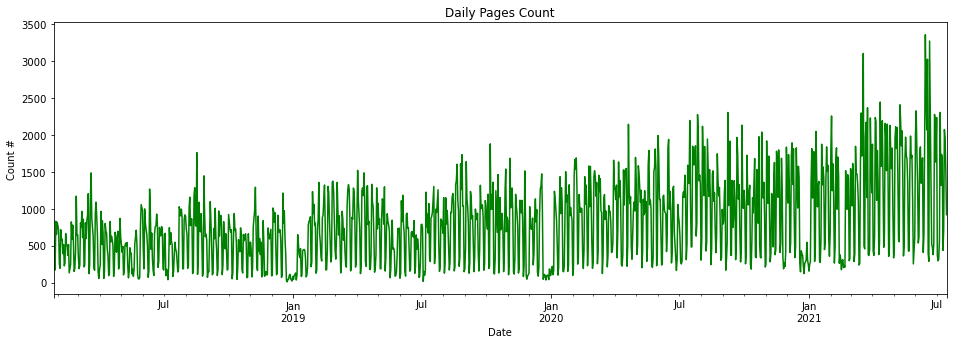

In [6]:
pages.plot()
plt.title('Daily Pages Count')
plt.xlabel('Date')
plt.ylabel('Count #')
None

### Exponential Moving Average (EMA)
>- Limitations- SMA values lag the original. Changes only seen with delay of L units
>- EMA helps reduce lag by use of SMA- applies more weight on recent observations(SMA weights all obsevations)

EMAt = α ∗ (t0 − EMAt−1) + EMAt−1 
- M = Number of time periods, span of the window

- t0 = Latest value

- t−1 = Previous value
- EMAt − 1 = Exponential moving average of previous day.

- The multiplier: 
    α=2 = (2 / (M+1))

- M = span argument = number of time periods. (We will try 7 days, 14 days, and 30 days).

Notice how there are no missing values. __ewm()__ will use as many values are available to compute the mean. So if the span is 7 days, but it is on the first day of data available, the EMA will equal the first value.

In [7]:
# 7 day EMA

ema_7d = pages.ewm(span = 7).mean()
ema_7d

2018-01-26     572.000000
2018-01-27     376.571429
2018-01-28     287.243243
2018-01-29     485.737143
2018-01-30     540.235595
                 ...     
2021-07-11    1066.269733
2021-07-12    1317.952300
2021-07-13    1477.464225
2021-07-14    1492.598169
2021-07-15    1349.198627
Freq: D, Name: page, Length: 1267, dtype: float64

In [8]:
# two weeks day EMA

ema_14d = pages.ewm(span = 14).mean()
ema_14d.head()

2018-01-26    572.000000
2018-01-27    388.785714
2018-01-28    305.208829
2018-01-29    465.757252
2018-01-30    514.347700
Freq: D, Name: page, dtype: float64

In [9]:
# 3 months (90 days) day EMA

ema_30d = pages.ewm(span = 30).mean()
ema_30d.head()

2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: page, dtype: float64

In [10]:
# 3 months (90 days) day EMA

ema_90d = pages.ewm(span = 90).mean()
ema_90d.head()

2018-01-26    572.000000
2018-01-27    399.100000
2018-01-28    321.030081
2018-01-29    452.545042
2018-01-30    494.228442
Freq: D, Name: page, dtype: float64

### Plot ewm

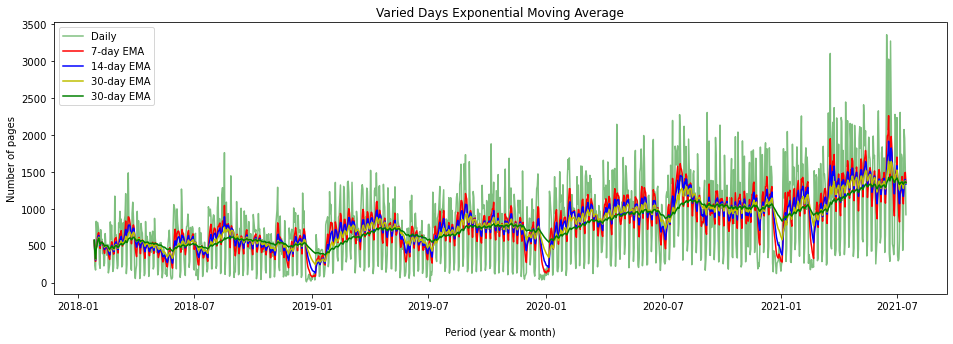

In [42]:
fig, ax = plt.subplots(figsize=(16,5))

ax.plot(pages.index, pages, label='Daily', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '30-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')
ax.set_xlabel('\nPeriod (year & month)')
ax.set_title('Varied Days Exponential Moving Average')

plt.show()


## Bollinger Bands and %b
Bollinger Bands

a volatility indicator and commonly used in stock market trading.

Made up of 3 lines, the Upper Band (UB), the Lower Band (LB) and the Midband.

### Midband

The Exponential Moving Average

midband = train.ewm(span=30).mean()

### Upper & Lower Band

UB/LB = Midband +/- stdev * K

stdev = train.ewm(span=30).std()

K = the number of standard deviations to go up and down from the EMA

### %b, Percent Bandwidth

Shows where the last value sits in relation to the bands

%
b
=
l
a
s
t
−
L
B
U
B
−
L
B

%b > 1 => point lies above UB

%b < 0 => point lies below LB

%b == .5 => point lies on the midband.

### Bandwidth

The width of the bands

B
a
n
d
w
i
d
t
h
=
(
U
B
−
L
B
)
M
i
d
b
a
n
d


In [20]:
# set the window span
span = 30

# compute midband
midband = pages.ewm(span = span).mean()

midband.head()


2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: page, dtype: float64

In [22]:
# compute exponential stdev
stdev = pages.ewm(span = span).std()

stdev.head()

2018-01-26           NaN
2018-01-27    241.830519
2018-01-28    213.878138
2018-01-29    316.467837
2018-01-30    284.479727
Freq: D, Name: page, dtype: float64

In [39]:
# compute upper and lower bands
ub = midband + stdev * 3
lb = midband - stdev * 3

# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis = 1)


In [40]:
# Concatenate the dfs
my_df = pd.concat([pages, midband, bb], axis=1)
my_df.columns = ['pages', 'midband', 'upper_band', 'lower_band']
my_df.head()


,pages,midband,upper_band,lower_band
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557
2018-01-28,170,315.139578,956.773991,-326.494835
2018-01-29,830,457.002386,1406.405897,-492.401124
2018-01-30,652,501.369064,1354.808245,-352.070116


### Plot the bands

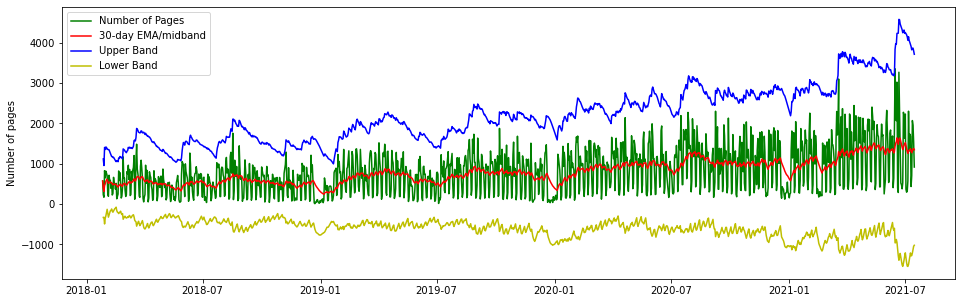

In [44]:
fig, ax = plt.subplots(figsize=(16,5))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.upper_band, label = 'Upper Band')
ax.plot(my_df.index, my_df.lower_band, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()


#### Computer %b


%b = (last − Lower_Band) / (Upper_Band − Lower_Band)

In [45]:
# get the last measure of gb
last_measure = my_df.iloc[-1].pages
last_measure

919.0

In [47]:
# get the lower band value on the last date
last_lb = my_df.iloc[-1].lower_band
last_lb


-1021.4076601733216

In [48]:
# get the upper band value on the last date
last_ub = my_df.iloc[-1].upper_band
last_ub


3717.907020003997

In [49]:
# compute %b
last_pct_b = (last_measure - last_lb)/(last_ub - last_lb)

print('%b for last datapoint: ', round(last_pct_b, 2))


%b for last datapoint:  0.41


### Each point in time

In [52]:
my_df['pct_b'] = (my_df['pages'] - my_df['lower_band'])/(my_df['upper_band'] - my_df['lower_band'])
my_df.head()

,pages,midband,upper_band,lower_band,pct_b
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557,0.386077
2018-01-28,170,315.139578,956.773991,-326.494835,0.386899
2018-01-29,830,457.002386,1406.405897,-492.401124,0.696438
2018-01-30,652,501.369064,1354.808245,-352.070116,0.588249


### Anomalies = (%b > 1)

In [56]:
my_df[my_df['pct_b'] > 1]

,pages,midband,upper_band,lower_band,pct_b


### Computed Functions

In [58]:
def acquire(file_name, column_names):
    return pd.read_csv(file_name, sep="\s", header=None, names=column_names, usecols=[0, 2, 3, 4, 5])

def prep(df, user):
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    pages = df['endpoint'].resample('D').count()
    return pages

def compute_pct_b(pages, span, weight, user):
    midband = pages.ewm(span=span).mean()
    stdev = pages.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    bb = pd.concat([ub, lb], axis=1)
    my_df = pd.concat([pages, midband, bb], axis=1)
    my_df.columns = ['pages', 'midband', 'upper_band', 'lower_band']
    my_df['pct_b'] = (my_df['pages'] - my_df['lower_band'])/(my_df['upper_band'] - my_df['lower_band'])
    my_df['user_id'] = user
    return my_df

def plt_bands(my_df, user):
    fig, ax = plt.subplots(figsize=(16,6))
    ax.plot(my_df.index, my_df.pages, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()

def find_anomalies(df, user, span, weight):
    pages = prep(df, user)
    my_df = compute_pct_b(pages, span, weight, user)
    # plt_bands(my_df, user)
    return my_df[my_df.pct_b > 1]
